<a href="https://colab.research.google.com/github/jhqthai/xray-pneumonia-detection/blob/master/pneumonia_detection_v_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pneumonia detection v.2
Hardware: Google Collab GPU

Software: Tensorflow, Keras

Dataset: 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
https://data.mendeley.com/datasets/rscbjbr9sj/2

Model: VGG16- Premade Keras

Resources:
https://medium.com/unit8-machine-learning-publication/detecting-pneumonia-on-x-ray-images-covnets-and-transfer-learning-6d94b58c6657


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 74kB/s 
     |████████████████████████████████| 450kB 29.2MB/s 
     |████████████████████████████████| 3.8MB 34.3MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

1.15.0


## Upload dataset

In [3]:
# Make folder for chest xray data
!mkdir /content/data/ 

# Download dataset
!wget --no-check-certificate \
    https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz \
    -O /content/data/chest_xray.tar.gz
  
# Extract dataset
import os
import tarfile

tar = tarfile.open("data/chest_xray.tar.gz")
tar.extractall(path='./data/')
os.remove('data/chest_xray.tar.gz')

--2019-10-24 03:03:18--  https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.111
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225393795 (1.1G) [application/x-gzip]
Saving to: ‘/content/data/chest_xray.tar.gz’

/content/data/chest 100%[===================>]   1.14G  94.8MB/s    in 13s     

2019-10-24 03:03:31 (87.9 MB/s) - ‘/content/data/chest_xray.tar.gz’ saved [1225393795/1225393795]



## Data prep and manipulation

In [74]:
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator # Data preprocessing and augmentation

TRAINING_DIR = "/content/data/chest_xray/train"
VALIDATION_DIR = "/content/data/chest_xray/val"
TEST_DIR = "/content/data/chest_xray/test"

# TODO: Data augmentation - Fiddle with images for training
training_datagen = ImageDataGenerator(
    rescale = 1./255,
    # rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Create training data batch
# TODO: Try grayscaling the image to see what will happen
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150), # Resize the image to 150px x 150px; Why? idk... Check Unit8 work..
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical',
    shuffle=False
)

train_generator.image_shape

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


(150, 150, 3)

## Define the Model - Transfer Learning

Using VGG16 model pretrained on Imagenet available on Keras.

> reusing pre-trained part of the network that is responsible for features learning

> retrain the classification part

![](https://miro.medium.com/max/4696/1*YrsPJxR2iQCCuH6pgciSfA.png)

In [5]:
# from keras.models import Model
# from keras.layers import Flatten, Dense, BatchNormalization, Dropout
# from keras.applications.vgg16 import VGG16

tf.keras.backend.clear_session() # Destroys the current TF graph and creates a new one.

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, 'softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
58892288/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128

### Reduce the number of trained parameters

Block out the first 20 layers of the model (up to the Flatten phase). Only train the last layer.


In [0]:
# def print_layers(model):
#     for idx, layer in enumerate(model.layers):
#         print("layer {}: {}, trainable: {}".format(idx, layer.name, layer.trainable)) # Debug view

In [0]:
for layer in model.layers[0:20]:
    layer.trainable = False
    
# print_layers(model) # Debug view

## Compile the Model

Set optimiser, loss function and callbacks functions

In [0]:
optimizer = 'rmsprop'
model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
# Make directory to save weights
!mkdir /content/data/model


# Make directory to logs for Tensorboard
!mkdir /content/data/graph

In [0]:
# Callbacks stuff
# Function to save the weights of the model after each epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/data/model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss',
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# Function to write logs for TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(
    log_dir='/content/data/graph',
    histogram_freq=0,
    write_graph=True
)

# Function to stop training early if there's no improvement
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = "val_acc", mode="auto", verbose = 1)

The training set is un-balance (known from conducting data analysis previously).

Calculate the classweight to emphasised focus on the under-represent class during training. Weight balancing can resolve problem with accuracy and loss.

In [10]:
import sklearn
import numpy as np
classweight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(train_generator.labels), train_generator.labels)
print(classweight)

[1.9448173  0.67303226]


## Train the model

In [11]:
# This may need quite a few fixes
history = model.fit_generator(
    generator=train_generator, 
    # steps_per_epoch=500, 
    epochs=10,
    # callbacks=[early_stopping_monitor],
    callbacks=[checkpoint, tensorboard, early_stopping_monitor],
    shuffle=True, 
    validation_data=validation_generator, 
    # validation_steps=10, 
    class_weight=classweight,
    verbose = 1
    )

model.save("pneumonia_detection_v2.h5")

Epoch 1/10
  1/163 [..............................] - ETA: 5:09 - loss: 0.2379 - acc: 0.8750
Epoch 00001: saving model to /content/data/model/weights.epoch_01.hdf5
163/163 [==============================] - 93s 570ms/step - loss: 0.2275 - acc: 0.9055 - val_loss: 0.2379 - val_acc: 0.8750
Epoch 2/10
  1/163 [..............................] - ETA: 1:00 - loss: 0.2906 - acc: 0.8750
Epoch 00002: saving model to /content/data/model/weights.epoch_02.hdf5
163/163 [==============================] - 89s 546ms/step - loss: 0.1559 - acc: 0.9354 - val_loss: 0.2906 - val_acc: 0.8750
Epoch 3/10
  1/163 [..............................] - ETA: 1:00 - loss: 0.2502 - acc: 0.8125
Epoch 00003: saving model to /content/data/model/weights.epoch_03.hdf5
163/163 [==============================] - 90s 552ms/step - loss: 0.1358 - acc: 0.9498 - val_loss: 0.2502 - val_acc: 0.8125
Epoch 00003: early stopping


## Evaluate the Model

In [82]:
test_loss, test_acc = model.evaluate_generator(generator=test_generator, verbose=1)

20/20 [==============================] - 7s 362ms/step - loss: 0.2562 - acc: 0.9135


## Analytics



In [0]:
print(tensorboard.log_dir)
%tensorboard - logdir /content/data/graph

Error: A logdir or db must be specified. For example `tensorboard --logdir mylogdir` or `tensorboard --db sqlite:~/.tensorboard.db`. Run `tensorboard --helpfull` for details and examples.


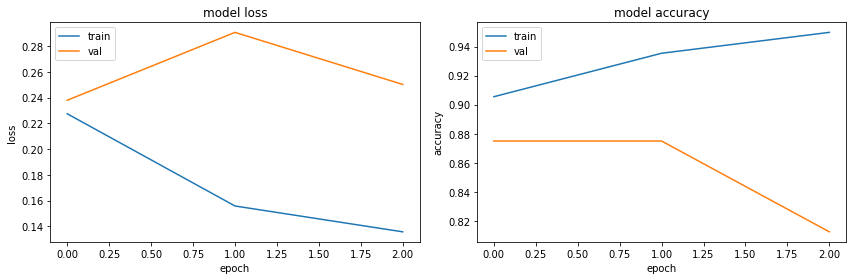

In [14]:
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)

### Test metrics

Pneumonia detection with confusion matrix sample: https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8

A simple example: Confusion Matrix with Keras flow_from_directory.py
Source: https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

Why reset test_generator? https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720



20/20 [==============================] - 7s 373ms/step
CONFUSION MATRIX ------------------


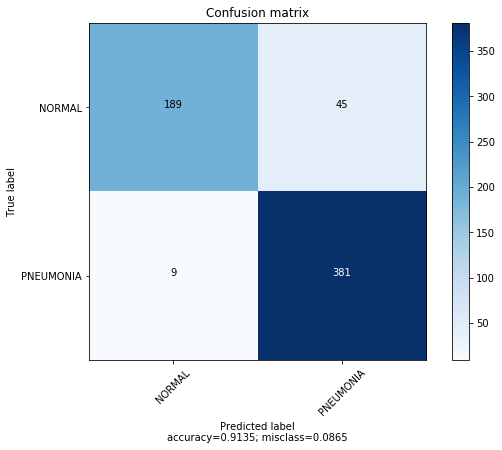


TEST METRICS ----------------------
Accuracy: 91.34615384615384%
Precision: 89.43661971830986%
Recall: 97.6923076923077%
F1-score: 93.38235294117646

TRAIN METRIC ----------------------
Train acc: 94.9769914150238%


In [94]:
from sklearn.metrics import accuracy_score, confusion_matrix

test_generator.reset()
test_preds = model.predict_generator(test_generator, verbose=1)
test_preds = np.argmax(test_preds,axis=1)

acc = accuracy_score(test_generator.classes, test_preds)*100
cm = confusion_matrix(test_generator.classes, test_preds)
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)
# plot_confusion_matrix(cm, target_names=['NORMAL', 'PNEUMONIA'], normalize=False)


print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}%'.format(np.round((history.history['acc'][-1])*100, 14)))

### View augmented images

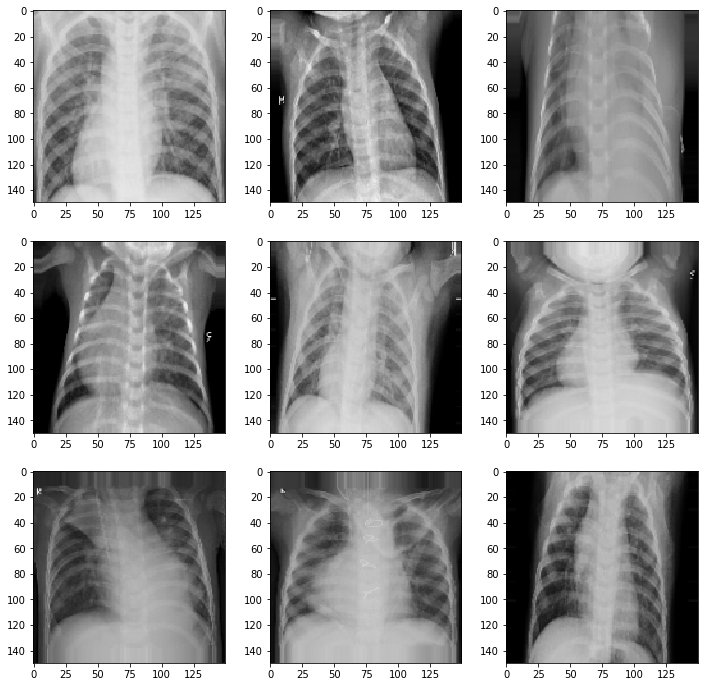

In [49]:
import matplotlib.pyplot as plt

x,y = train_generator.next()
plt.figure(figsize=(12, 12))
for i in range(0,9):
  plt.subplot(330 + 1 + i)
  image = x[i]
  plt.imshow(image)
plt.show()

### View images

In [0]:
import numpy as np

def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [0]:

x, y = get_labeled_files('./data/chest_xray/train/')

list(zip(x, y))[:10]

[('./data/chest_xray/train/NORMAL/NORMAL2-IM-1305-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-0678-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-1124-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0156-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0734-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0724-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-1288-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0738-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/IM-0455-0001.jpeg', 0),
 ('./data/chest_xray/train/NORMAL/NORMAL2-IM-1158-0001.jpeg', 0)]

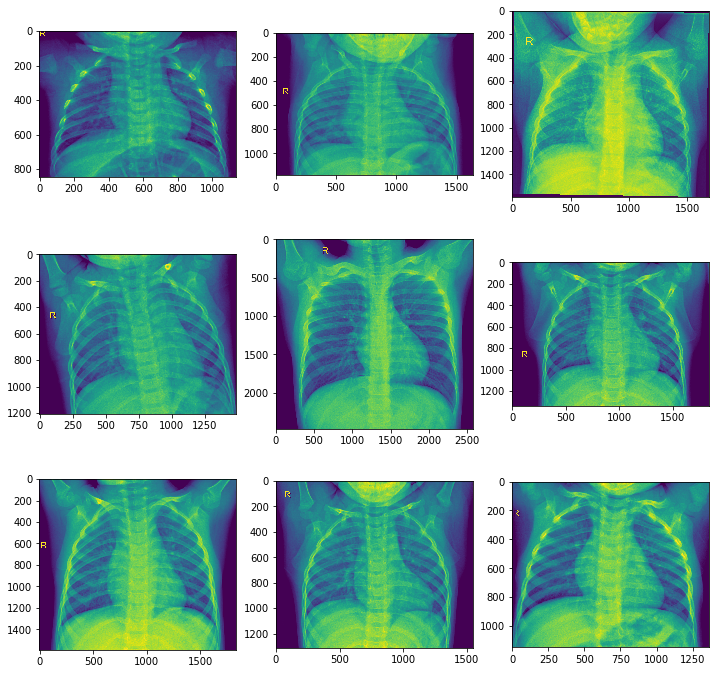

In [0]:
plt.figure(figsize=(12, 12))
for i in range(0,9):
  plt.subplot(330 + 1 + i)
  image = plt.imread(x[i])
  plt.imshow(image) #, cmap='gray')
plt.show()

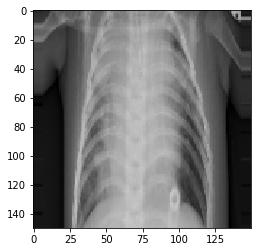

64


In [63]:
test_data, test_labels = next(test_generator)
train_data, train_labels = next(train_generator)


image = train_data[1]
plt.imshow(image)
plt.show()

print(test_labels.size)